In [1]:
!hdfs dfsadmin -fs hdfs://nn:9000/ -report

Configured Capacity: 25821052928 (24.05 GB)
Present Capacity: 11137617920 (10.37 GB)
DFS Remaining: 10939142144 (10.19 GB)
DFS Used: 198475776 (189.28 MB)
DFS Used%: 1.78%
Replicated Blocks:
	Under replicated blocks: 17
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 17
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 172.24.0.5:9866 (project-5-p5_yw_ym-dn-1.project-5-p5_yw_ym_default)
Hostname: 8579c9528396
Decommission Status : Normal
Configured Capacity: 25821052928 (24.05 GB)
DFS Used: 198475776 (189.28 MB)
Non DFS Used: 14666657792 (13.66 GB)
DFS Remaining: 10939142144 (10.19 GB)
DFS Used%: 0.77%
DFS Rem

In [2]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/


In [3]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/04 21:00:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#q1
banks_df = spark.read.option("header", "true").option("inferSchema", "true") \
              .csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")
banks_df.write.mode("overwrite").saveAsTable("banks")
banks_df.rdd.filter(
    lambda row: "The" in row['respondent_name'] and "National" in row['respondent_name']
).count()

24/04/04 21:01:33 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/04 21:01:33 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/04 21:01:39 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/04 21:01:39 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.24.0.4
24/04/04 21:01:40 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/04/04 21:01:46 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/04/04 21:01:46 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/04/04 21:01:46 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/04 21:01:46 W

106

In [5]:
#q2
banks_df.filter(
    banks_df['respondent_name'].contains("The") & banks_df['respondent_name'].contains("National")
).count()

106

In [6]:
#q3
#banks_df.createOrReplaceTempView("banks")

df3 = spark.sql("""
SELECT COUNT(*) as count
FROM banks
WHERE respondent_name LIKE '%The%' AND respondent_name LIKE '%National%'
""").toPandas().head()
df3.iloc[0]['count']

106

In [7]:
loans_df = (spark.read.option("header", "true")
            .option("inferSchema", "true")
            .csv("hdfs://nn:9000/hdma-wi-2021.csv"))
loans_df.write.bucketBy(8, "county_code").mode("overwrite").saveAsTable("loans")

24/04/04 21:02:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
views = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for view_name in views:
    df = (spark.read
          .option("header", "true")
          .option("inferSchema", "true")
          .csv(f"hdfs://nn:9000/{view_name}.csv")
          .createOrReplaceTempView(view_name))

In [9]:
#q4
name = spark.sql("SHOW TABLES").collect()
name_table = {row.tableName: row.isTemporary for row in name}
name_table

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [10]:
#q5
result = spark.sql("""
    SELECT COUNT(*) AS application_count
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name = 'First National Bank'
""").toPandas()
result['application_count'][0]

6

In [11]:
#q6
spark.sql("""
    SELECT COUNT(*) AS application_count
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name = 'First National Bank'
""").explain("formatted")
#  1. the 'banks' table, because bank table is a small table, and spark optimizes joining operation by sending small table
# to all executors.
#  2. Yes, it does. The first time occurs in step 9 after Project(step 8).
#     The second time occurs in step 11 after Exchange(step 10). Because we use count for aggregation function, it should have 
#     HashAggregate. 

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildLeft (7)
               :- BroadcastExchange (4)
               :  +- Project (3)
               :     +- Filter (2)
               :        +- Scan parquet spark_catalog.default.banks (1)
               +- Filter (6)
                  +- Scan parquet spark_catalog.default.loans (5)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#66, lei_2020#70]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,First National Bank), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#66, lei_2020#70]
Condition : ((isnotnull(respondent_name#66) AND (respondent_name#66 = First National Bank)) AND isnotnull(lei_2020#70))

(3) Projec

In [12]:
#q7
avg_loan = spark.sql("""
    SELECT 
        l.county_code, 
        AVG(l.loan_amount) AS average_loan_amount
    FROM loans l
    INNER JOIN banks b 
    ON l.lei = b.lei_2020
    WHERE UPPER(TRIM(b.respondent_name)) LIKE '%WELLS FARGO%'
    GROUP BY l.county_code
    ORDER BY average_loan_amount DESC
    LIMIT 10
""")
avg_loan.createOrReplaceTempView("top_wells_fargo_counties")

avg_loan_df = avg_loan.toPandas()

counts_df = spark.sql("""
    SELECT c.name AS county_name, 
        COUNT(*) AS application_count
    FROM  loans l
    INNER JOIN  banks b 
    ON l.lei = b.lei_2020
    INNER JOIN  top_wells_fargo_counties twfc 
    ON  l.county_code = twfc.county_code
    INNER JOIN counties c 
    ON l.county_code = c.STATE*1000 + c.COUNTY
    WHERE UPPER(TRIM(b.respondent_name)) LIKE '%WELLS FARGO%'
    GROUP BY twfc.county_code, c.name, twfc.average_loan_amount
    ORDER BY twfc.average_loan_amount DESC
""")

counts_df_pd = counts_df.toPandas()
df_dict = counts_df_pd.set_index('county_name')['application_count'].to_dict()
df_dict

{'Sawyer': 38,
 'Door': 174,
 'Forest': 7,
 'Ozaukee': 389,
 'Bayfield': 33,
 'Waukesha': 1832,
 'Vilas': 68,
 'Dane': 729,
 'Oneida': 70,
 'Florence': 8}

Text(0, 0.5, 'application_count')

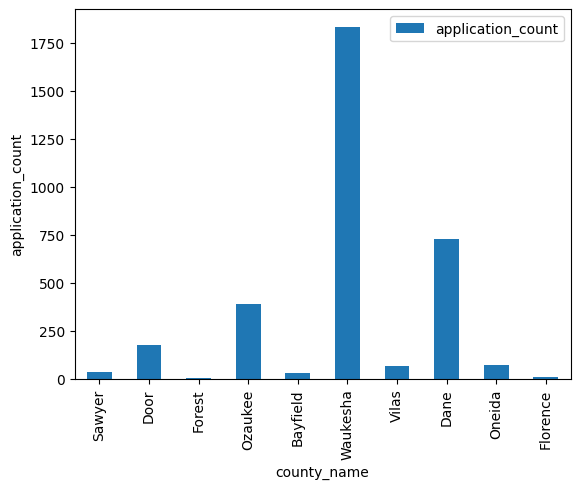

In [13]:
import matplotlib.pyplot as plt
counts_df_pd.set_index('county_name').plot.bar().set_ylabel('application_count')

In [14]:
#q8
county_group_query = spark.sql("SELECT county_code, MEAN(loan_amount) FROM loans GROUP BY county_code")
county_group_query.explain()

lei_group_query = spark.sql("SELECT lei, MEAN(loan_amount) FROM loans GROUP BY lei")
lei_group_query.explain()
#  Because we already bucket the data by county_code, we don't need IO operation. 
#  We require network I/O when computing the mean grouping by lei because the data is not partitioned or bucketed by lei,
# we need IO operation to transform data.


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#992], functions=[mean(loan_amount#1009)])
   +- HashAggregate(keys=[county_code#992], functions=[partial_mean(loan_amount#1009)])
      +- FileScan parquet spark_catalog.default.loans[county_code#992,loan_amount#1009] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,loan_amount:double>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#989], functions=[mean(loan_amount#1009)])
   +- Exchange hashpartitioning(lei#989, 200), ENSURE_REQUIREMENTS, [plan_id=1412]
      +- HashAggregate(keys=[lei#989], functions=[partial_mean(loan_amount#1009)])
         +- FileScan parquet spark_catalog.default.loans[lei#989,loan_amount#1009] Batched: true, Bucketed: false (bucke

In [15]:
from pyspark.sql.functions import col, when
df = spark.table("loans").withColumn("approval", when(col("action_taken") == 1, 1).otherwise(0))
df = df.select(
    col("loan_amount").cast("double"),
    col("income").cast("double"),
    col("interest_rate").cast("double"),
    "approval"
)
df = df.na.fill(0.0, subset=["loan_amount", "income", "interest_rate", "approval"])
df.show()

+-----------+------+-------------+--------+
|loan_amount|income|interest_rate|approval|
+-----------+------+-------------+--------+
|   255000.0| 210.0|          0.0|       1|
|   435000.0|   0.0|        3.125|       0|
|   435000.0| 190.0|          0.0|       1|
|   165000.0|   0.0|         3.25|       0|
|   205000.0|   0.0|          0.0|       1|
|   305000.0|   0.0|          3.5|       0|
|   195000.0|  43.0|         2.75|       1|
|   185000.0|   0.0|          3.5|       0|
|   265000.0|  93.0|         2.75|       1|
|   185000.0|   0.0|         3.25|       0|
|   475000.0|   0.0|        1.999|       1|
|   235000.0|   0.0|         3.25|       0|
|   425000.0|   0.0|          2.0|       1|
|   235000.0|   0.0|         3.25|       0|
|   185000.0|   0.0|         2.25|       1|
|   385000.0|   0.0|          3.0|       0|
|   365000.0| 321.0|        2.625|       1|
|   155000.0|   0.0|          2.5|       0|
|   245000.0|   0.0|         3.75|       1|
|   315000.0|   0.0|          3.

In [16]:
#q9
train, test = df.randomSplit([0.8, 0.2], seed=41)
train.cache()
count = train.where(col("approval") == 1).count()
count

242868

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
transformed_train = va.transform(train)
transformed_test= va.transform(test)

transformed_train.show()

+-----------+------+-------------+--------+----------------+
|loan_amount|income|interest_rate|approval|        features|
+-----------+------+-------------+--------+----------------+
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|    

In [18]:
#q10
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(labelCol="approval", featuresCol="features", numTrees=10)
model = rf.fit(transformed_train)

predictions = model.transform(transformed_test)

evaluator = MulticlassClassificationEvaluator(
    labelCol="approval", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
accuracy

0.8937543828404145